<a href="https://colab.research.google.com/github/tpias-thinksense/Missing-Sample-Analysis-/blob/main/Sensor_Data_Analysis_Missing_Samples_OOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Missing Sample Analysis Class

In [247]:
# Import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt


# Connect to google drive first or upload the file
# This is to set working directory so that can access necessary files just by using name of the file
%cd /content/drive/MyDrive/Dataset/Sensor Data - Missing Samples


'''
Class for missing sensor sample analysis
Variables:
  1. raw_sensor_data: Raw sensor data stored as pandas DataFrame. 
Functions:
  1. Constructor: takes JSON file path as only argument. By default file name set to: 10% bat, speeping, app in backg_acc.txt
  It reads the json file and stores it as a pandas DataFrame for later use. This dataframe can be accessed by raw_sensor_data variable.

  2. trim_data: Takes start time (s) and end time (s) to slice the raw dataframe. 
  It also adds more information in the dataframe such as 
'''
class Missing_Data_Analysis():

  def __init__(self, file = '10% bat, speeping, app in backg_acc.txt'):
    self.file = file
    self.missed_samples_df = None
    with open(self.file,'r') as f:
        data = json.loads(f.read())

    # Normalizing data
    self.raw_sensor_data = pd.json_normalize(data, record_path =['records'], record_prefix='Acc_')
    print(" ------------------------------- Raw data reading complete -------------------------------")
    #print(self.raw_sensor_data)




  def trim_data(self, start_time = 30.0, end_time = 180.0):

    dt = [] # keeps sampling period 
    duration = 0 # time from the raw start point (s)
    duration2 = 0 # time from the trimmed start point (s)
    duration_ms2 = 0 # time from the trimmed start point (ms)
    counter = 1 # keep track of number of samples
    ideal_period = 200 #ms
    ideal_duration_ms2 = 0 #ms
    x = self.raw_sensor_data # storing raw sensor data in a temporary variable 


    sensor_dict = {
        'time_stamp (ms)': [], # this is system timestamp taken from raw sensor data
        'sample_count (#)': [], # sample number
         'time elapsed (s)': [], # this elapsed time is calculated from very begining when raw data was collected
         'time elapsed2 (s)': [], # this elapsed time starts from trimmed data
         'time elapsed2 (ms)': [], # this commulative elapsed time starts from trimmed data
         'sample period (ms)': [], # this calculates the sampling period 
         'ideal period (ms)': [], # this stores ideal sample period which is 200 for this scenario
         'ideal time elapsed2 (ms)': [], # elapsed time from starts from trimmed data if the sensors acted like ideal 
         'Acc_x': [], # x component of accelerometer sensor
         'Acc_y': [], # y component of accelerometer sensor
         'Acc_z': [], # z component of accelerometer sensor
    }
    
    for i in range(x.shape[0]-1):
      dx = x.iloc[i+1]['Acc_timestamp'] - x.iloc[i]['Acc_timestamp'] # Sampling period = (i+1)th time stamp - i-th time stamp
      dt.append(dx)
      duration += (dt[-1]/1000) # converting to seconds from miliseconds

      
      if duration >= start_time and duration <= end_time: # slice by time frame
        duration2 += (dt[-1]/1000) # comulative sampling period in seconds
        duration_ms2 += dt[-1] # comulative sampling period in miliseconds
        ideal_duration_ms2 += ideal_period # comulative ideal sampling period

        sensor_dict['time_stamp (ms)'].append(x.iloc[i+1]['Acc_timestamp'])
        sensor_dict['sample_count (#)'].append(counter)
        sensor_dict['time elapsed (s)'].append(round(duration, 3))
        sensor_dict['time elapsed2 (s)'].append(round(duration2, 3))
        sensor_dict['time elapsed2 (ms)'].append(duration_ms2)
        sensor_dict['sample period (ms)'].append(dt[-1])
        sensor_dict['ideal period (ms)'].append(ideal_period)
        sensor_dict['ideal time elapsed2 (ms)'].append(ideal_duration_ms2)
        sensor_dict['Acc_x'].append(x.iloc[i+1]['Acc_x'])
        sensor_dict['Acc_y'].append(x.iloc[i+1]['Acc_y'])
        sensor_dict['Acc_z'].append(x.iloc[i+1]['Acc_z'])

        #print(counter, round(duration, 3), dt[-1], x.iloc[i+1]['Acc_x'], x.iloc[i+1]['Acc_y'], x.iloc[i+1]['Acc_z'])
        counter +=1 

    self.sensor_data_preprocessed = pd.DataFrame(sensor_dict) # convert dictonary to dataframe
    #print(self.sensor_data_preprocessed)

    #self.sample = [i+1 for i in range(len(self.ideal_dt))]
    print("------------------------------- Data Preprocess Complete -------------------------------")
    
  '''
  this method returns preprocessed sensor data
  '''
  def print_preprocessed_data(self):
    return self.sensor_data_preprocessed
  
  '''
  this method return raw sensor data
  '''
  def print_raw_data(self):
    return self.raw_sensor_data
  

  '''
  Description: this method calculates missing samples within a given window (interval)

  Input arguments:
  starting_time = start time of the window in ms
  ending_time = end time of the window in ms
  verbose = 1 => to print information and calculation, 0 => no print

  Return:
  total missing samples (#) within the given window
  '''
  def missing_samples(self, starting_time = 0, ending_time = 14000, verbose = 0):
    
    # slice by time frame
    total_recorded_samples = self.sensor_data_preprocessed[ (self.sensor_data_preprocessed['time elapsed2 (ms)'] >= starting_time) &  (self.sensor_data_preprocessed['time elapsed2 (ms)'] <= ending_time)].shape[0]
    self.sampling_rate = 200 #ms
    total_expected_samples = (ending_time //self.sampling_rate  - starting_time //self.sampling_rate )
    total_missing_samples = total_expected_samples - total_recorded_samples

    if verbose == 1:
      print("Start time (ms): ", starting_time)
      print("End time (ms): ", ending_time)
      print("Time frame (ms): ", ending_time - starting_time)
      print('Ideal sampling period (ms): ', self.sampling_rate)
      if total_recorded_samples != 0:
        print("Average sampling period (ms): ", (ending_time - starting_time)//total_recorded_samples)
      print('total_expected_samples (#): ', total_expected_samples)
      print('total_recorded_samples (#): ', total_recorded_samples)
      print('total_missing_samples (#): ', total_missing_samples)
      print("------------------------------------------")
      
    return total_missing_samples


  '''
  Description: This method calculates missing samples for the given interval

  Input arguments:
  interval = takes the interval in seconds

  Return:
  A pandas DataFrame containing missing sample count for every interval (ms)
  '''

  def calculate_missing_interval(self, interval = 1):
  
    interval_ms = interval*1000
    interval_start = []
    interval_end = []

    x = [] #missing_sample_counts
    point = 0 #pointer moves along the row

    time_elapsed_ms = self.sensor_data_preprocessed['time elapsed2 (ms)'].to_list()

    # if the given interval is larger than the recorded time, set interval to
    # max recoreded time
    if interval > time_elapsed_ms[-1]/1000:
      print(f"Given interval {interval}s is larger than total sensor reading time {time_elapsed_ms[-1]/1000}s")
      print(f"Interval is now set to {time_elapsed_ms[-1]/1000}s")
      interval_ms = time_elapsed_ms[-1]

    # loop until the las recoreded sample
    while point+interval_ms <= time_elapsed_ms[-1]:
      missed = self.missing_samples(point+1, point+interval_ms)

      x.append(missed)   
      interval_start.append(point+1)
      interval_end.append(point+interval_ms)

      point = point+interval_ms
    
    
    d = {
        'interval_start': interval_start,
         'interval_end' : interval_end,
         'missed samples': x
    }

    self.missed_samples_df = pd.DataFrame(d)
    return self.missed_samples_df



  '''
  Description: Plots the missing sample count for the given interval
  '''
  def plot_missing_intervals(self, interval = 1):
      self.calculate_missing_interval(interval)

      # this section adds a dummy row at the end 
      # to show the very last x_tick correctly 
      df = self.missed_samples_df
      interval_start = df['interval_start'].to_list()
      interval_end = df['interval_end'].to_list()
      diff = interval_end[-1] - interval_start[-1]
      new_row = {'interval_start': interval_end[-1], 'interval_end': interval_end[-1]+diff,  'missed samples': 0}
      df = df.append(new_row, ignore_index= True)
      
      plt.rcParams["figure.figsize"] = (20,6)
      bar_plot = df.plot.bar(x='interval_start', y='missed samples', rot=90, align='edge', width = 0.9)

      # Set labels and title
      plt.xlabel('Sampling Interval (ms)')
      plt.ylabel('Missed Samples (#)')
      title = str(self.file) + ": Missing Sample interval: " + str(interval) + "s = " +str(interval*1000) + "ms"
      plt.title(title)

      self.set_tick_font(df)

      plt.show()

  

  '''
  Description: Plots the missing sample count for the given interval. 
  Uses color map for better visualization
  '''
  def plot_missing_intervals_color(self, interval = 1):
    self.calculate_missing_interval(interval)
    plt.rcParams["figure.figsize"] = (20,6)
    plt.rcParams.update({'font.size': 16})

    # this section adds a dummy row at the end 
    # to show the very last x_tick correctly 
    df = self.missed_samples_df
    interval_start = df['interval_start'].to_list()
    interval_end = df['interval_end'].to_list()
    diff = interval_end[-1] - interval_start[-1]
    new_row = {'interval_start': interval_end[-1], 'interval_end': interval_end[-1]+diff,  'missed samples': 0}
    df = df.append(new_row, ignore_index= True)

    # Define a color map
    color_map = 'rainbow' #'coolwarm'
    # Normalize the values between 0 and 1
    norm = plt.Normalize(df['missed samples'].min(), df['missed samples'].max())
    # Create the color list using the color map
    colors = plt.cm.get_cmap(color_map)(norm(df['missed samples']))

    bar_plot = df.plot.bar(x='interval_start', y='missed samples', rot=90, align='edge', width = 0.9, color=colors, alpha=0.5)

    # Set labels and title
    plt.xlabel('Sampling Interval (ms)')
    plt.ylabel('Missed Samples (#)')
    title = str(self.file) + ": Missing Sample interval: " + str(interval) + "s = " +str(interval*1000) + "ms"
    plt.title(title)  

    self.set_tick_font(df)

    # Add a color bar
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, alpha=0.5)


    # Show the plot
    plt.show()


  '''
  An intenal method which sets the x tick values
  based on the x length, so that the x ticks
  doesn't overlap
  '''
  def set_tick_font(self, df):
    
    interval_start = df['missed samples'].to_list()
    info_count = len(interval_start)

    if info_count > 50:
      plt.tick_params(labelsize=5)
    if info_count > 30:
      plt.tick_params(labelsize=8)
    elif info_count > 20:
      plt.tick_params(labelsize=12)
    else:
      plt.tick_params(labelsize=14)


  '''
  Description: Calculates the missing sample count for each window. 
  The window size is defined by the interval argument.
  The window stride is defines by the slide variable.
  if slide variable is not given, it sets slide = interval which makes 
  this method same as calculate_missing_interval. 

  Return:
  A dataframe containing missing sample counts for each window
  '''
  
  def calculate_missing_window(self, interval = 1, slide = -1):

    # if interval is not given, slide is set to interval
    if slide == -1:
      slide = interval

    # convert s to ms
    interval_ms = interval*1000
    slide_ms = slide*1000

    interval_start = []
    interval_end = []
    intervals_start_end = []

    x = [] # missing sample counts
    point = 0 # a pointer moves along the rows
    time_elapsed_ms = self.sensor_data_preprocessed['time elapsed2 (ms)'].to_list()

    # if the given interval is larger than the recorded time, set interval to
    # max recoreded time
    if interval_ms > time_elapsed_ms[-1]:
      print(f"Given interval {interval}s is larger than total sensor reading time {time_elapsed_ms[-1]/1000}s")
      print(f"Interval is now set to {time_elapsed_ms[-1]/1000}s")
      interval_ms = time_elapsed_ms[-1]

    # loop until last record
    while point+interval_ms <= time_elapsed_ms[-1]:
      missed = self.missing_samples(point+1, point+interval_ms)

      x.append(missed)
      interval_start.append(point+1)
      interval_end.append(point+interval_ms)
      intervals_start_end.append(str(point+1) + "-" + str(point+interval_ms))

      point = point+slide_ms
    
    d = {
        'interval_start': interval_start,
         'interval_end' : interval_end,
         'intervals':intervals_start_end,
         'missed samples': x
    }

    self.missed_samples_window_df = pd.DataFrame(d)
    return self.missed_samples_window_df


  '''
  Plots missing samples for given window 
  '''
  def plot_missing_window(self, interval = 1, slide = -1):
    self.calculate_missing_window(interval, slide)
    plt.rcParams["figure.figsize"] = (20,6)

    df = self.missed_samples_window_df
    df.plot.bar(x = 'intervals', y = 'missed samples' , width = 0.9)

    # Set labels and title
    plt.xlabel('Sampling Interval (ms)')
    plt.ylabel('Missed Samples (#)')
    title = str(self.file) + ": Missing Sample interval: " + str(interval) + "s = " +str(interval*1000) + "ms"
    plt.title(title)

    #self.set_tick_font(df)

    plt.show()


  '''
  Plots missing samples for given window. Adds a color scale for better
  visualization.
  '''
  
  def plot_missing_window_color(self, interval = 1, slide = -1):
    self.calculate_missing_window(interval, slide)
    plt.rcParams["figure.figsize"] = (20,6)

    df = self.missed_samples_window_df
    
    x = df['intervals'].to_list()
    y = df['missed samples'].to_list()


    # Define color map and normalize the values
    color_map = plt.cm.get_cmap('rainbow')
    values = df['missed samples'].to_list()
    normalize = plt.Normalize(vmin=min(values), vmax=max(values))

    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=normalize)
    sm.set_array([])  # Set an empty array to avoid error
    plt.colorbar(sm, alpha=0.5)
    plt.xticks(rotation=90)
    plt.xlim([-0.5,len(x)-0.5])

    plt.bar(x, y, color=color_map(normalize(values)), alpha=0.5)

    # Set labels and title
    plt.xlabel('Sampling Interval (ms)')
    plt.ylabel('Missed Samples (#)')
    title = str(self.file) + ": Missing Sample interval: " + str(interval) + "s = " +str(interval*1000) + "ms"
    plt.title(title)

    plt.show()


  '''
  Plots cummulative sample period for each sample. Adds a color bar for 
  better visualization.
  '''

  def plot1(self):
    
    trimmed_dt_cm = self.sensor_data_preprocessed['time elapsed2 (ms)'].to_list()
    sample = [i+1 for i in range(len(trimmed_dt_cm))]
    trimmed_dt = self.sensor_data_preprocessed['sample period (ms)'].to_list()
    
    # Create subplots
    fig, ax = plt.subplots()

    # Plot data with different sampling frequencies
    plot = ax.scatter(x=trimmed_dt_cm, y=sample, vmin=0, vmax=10000, c =trimmed_dt, cmap = 'viridis', s=20)
    # Set plot title and labels
    ax.set_title(self.file)
    ax.set_xlabel('Elapsed Time - ms')
    ax.set_ylabel('n-th Sample')

    # Specify x-axis step
    plt.xticks(range(0, trimmed_dt_cm[-1], 10000), rotation = 90)  # Start: 1, Stop: 6, Step: 2

    # Specify y-axis step
    plt.yticks(range(1, len(trimmed_dt_cm)+1, 5))  # Start: 10, Stop: 20, Step: 2

    # Add legend
    ax.legend()

    # Show the plot
    plt.rcParams["figure.figsize"] = (20,6)

    plt.colorbar(plot)
    plt.grid()
    plt.show()


  '''
  Plots cummulative sample period for each sample and compares with ideal 
  sampling period. 
  '''

  def plot2(self):

    trimmed_dt_cm = self.sensor_data_preprocessed['time elapsed2 (ms)'].to_list()
    sample = [i+1 for i in range(len(trimmed_dt_cm))]
    trimmed_dt = self.sensor_data_preprocessed['sample period (ms)'].to_list()
    ideal_dt_cm = self.sensor_data_preprocessed['ideal time elapsed2 (ms)'].to_list() 

    # Create subplots
    fig, ax = plt.subplots()

    # Plot data with different sampling frequencies
    ax.scatter(ideal_dt_cm, sample, label='Ideal', s=10)
    ax.scatter(trimmed_dt_cm, sample, label='real',s=10)

    # Set plot title and labels
    ax.set_title(self.file)
    ax.set_xlabel('Elapsed Time')
    ax.set_ylabel('n-th Sample')

    # Add legend
    ax.legend()

    plt.rcParams["figure.figsize"] = (20,6)

    # Show the plot
    plt.grid()
    plt.show()


  '''
  Shows the sampling period for each sample
  '''
  def plot3(self, ylim=(190, 1000)):
    
    trimmed_dt_cm = self.sensor_data_preprocessed['time elapsed2 (ms)'].to_list()
    sample = [i+1 for i in range(len(trimmed_dt_cm))]
    trimmed_dt = self.sensor_data_preprocessed['sample period (ms)'].to_list()
    ideal_dt_cm = self.sensor_data_preprocessed['ideal time elapsed2 (ms)'].to_list() 

    # Create subplots
    fig, ax = plt.subplots()

    # Plot data with different sampling frequencies
    #ax.scatter( sample, ideal_dt, label='ideal')
    ax.scatter( sample, trimmed_dt, label='real')


    # Set plot title and labels
    ax.set_title(self.file)
    ax.set_xlabel('n-th sample')
    ax.set_ylabel('Sampling time')
    plt.ylim(ylim)

    # Add legend
    ax.legend()

    plt.rcParams["figure.figsize"] = (20,6)

    # Show the plot
    plt.grid()
    plt.show()

/content/drive/MyDrive/Dataset/Sensor Data - Missing Samples


In [248]:
obj = Missing_Data_Analysis('10% bat, speeping, app in backg_acc.txt')
obj.trim_data()

 ------------------------------- Raw data reading complete -------------------------------
------------------------------- Data Preprocess Complete -------------------------------


In [234]:
obj.missing_samples(0, 12000, verbose=1)

Start time (ms):  0
End time (ms):  12000
Time frame (ms):  12000
Ideal sampling period (ms):  200
Average sampling period (ms):  444
total_expected_samples (#):  60
total_recorded_samples (#):  27
total_missing_samples (#):  33
------------------------------------------


33

In [235]:
obj.calculate_missing_interval(1)

,interval_start,interval_end,missed samples
0,1,1000,2
1,1001,2000,2
2,2001,3000,1
3,3001,4000,2
4,4001,5000,1
...,...,...,...
123,123001,124000,5
124,124001,125000,5
125,125001,126000,5
126,126001,127000,5


<ipython-input-232-ea70ce5676b0>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index= True)


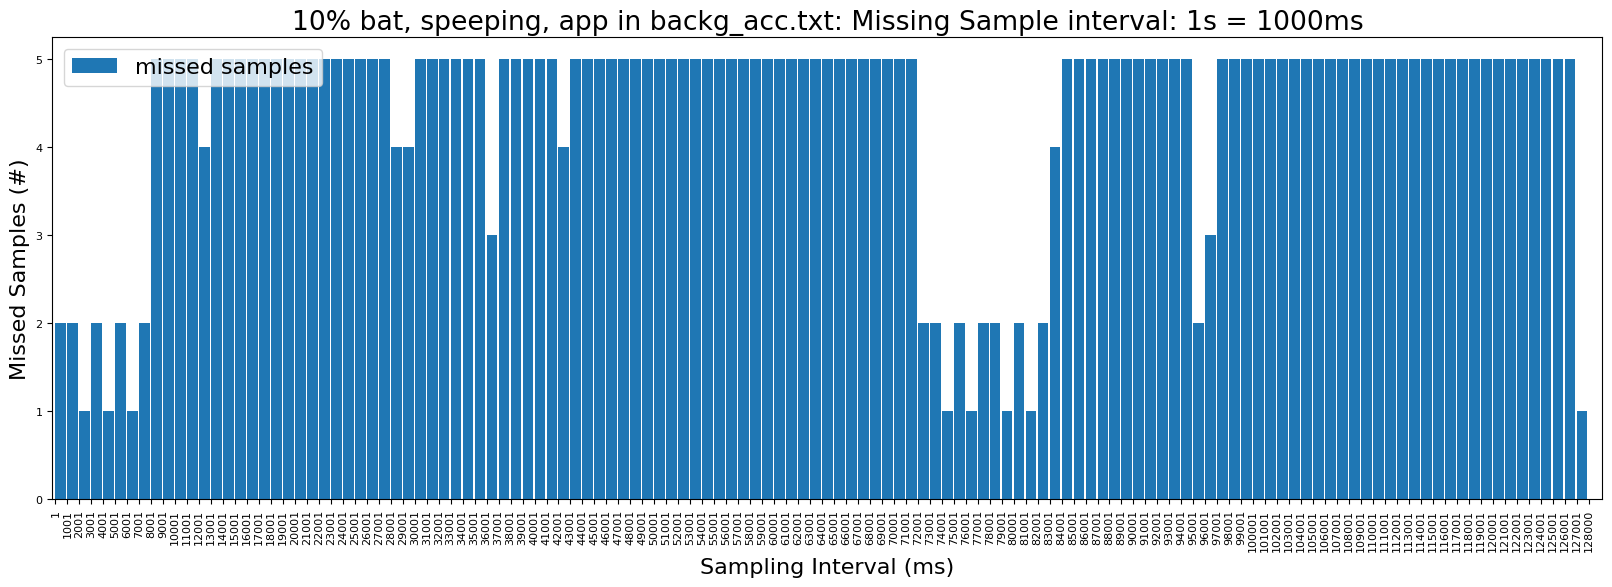

In [236]:
obj.plot_missing_intervals(1)

<ipython-input-247-de0a4d28cf2f>:240: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index= True)
<ipython-input-247-de0a4d28cf2f>:247: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(color_map)(norm(df['missed samples']))
<ipython-input-247-de0a4d28cf2f>:262: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, alpha=0.5)


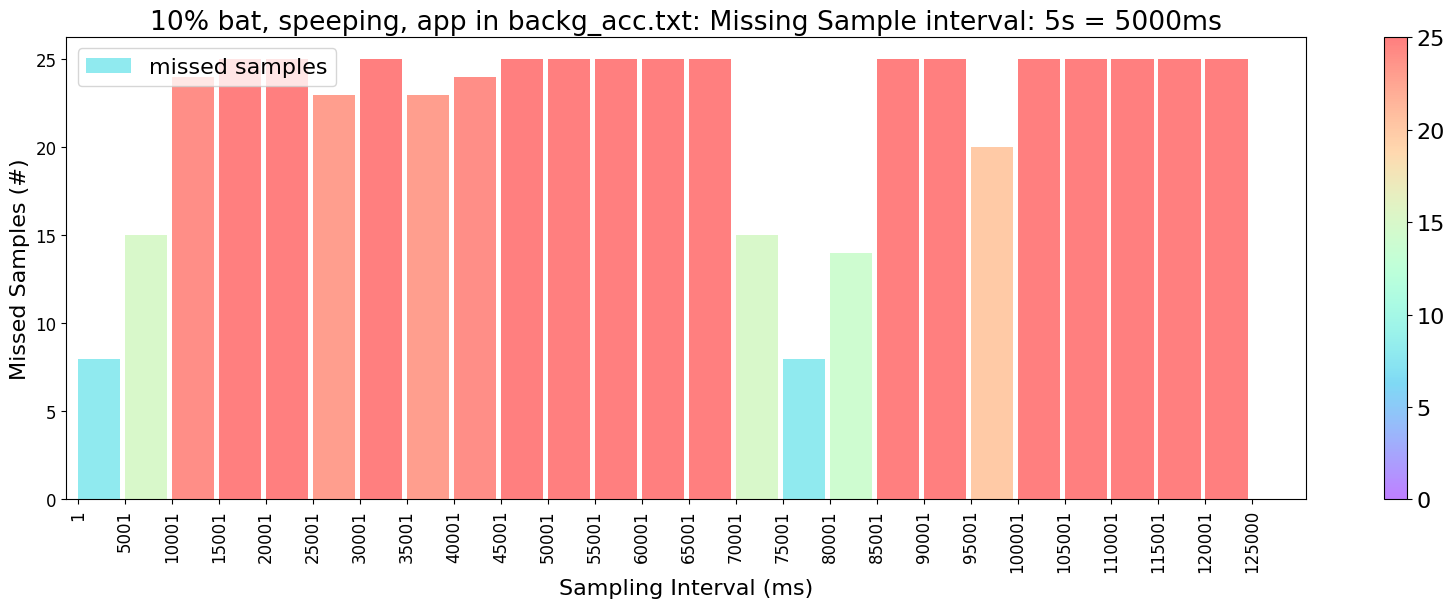

In [249]:
obj.plot_missing_intervals_color(5)

In [238]:
obj.calculate_missing_window(5, 3)

,interval_start,interval_end,intervals,missed samples
0,1,5000,1-5000,8
1,3001,8000,3001-8000,8
2,6001,11000,6001-11000,18
3,9001,14000,9001-14000,24
4,12001,17000,12001-17000,24
5,15001,20000,15001-20000,25
6,18001,23000,18001-23000,25
7,21001,26000,21001-26000,25
8,24001,29000,24001-29000,24
9,27001,32000,27001-32000,23


<ipython-input-247-de0a4d28cf2f>:384: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('rainbow')
<ipython-input-247-de0a4d28cf2f>:391: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, alpha=0.5)


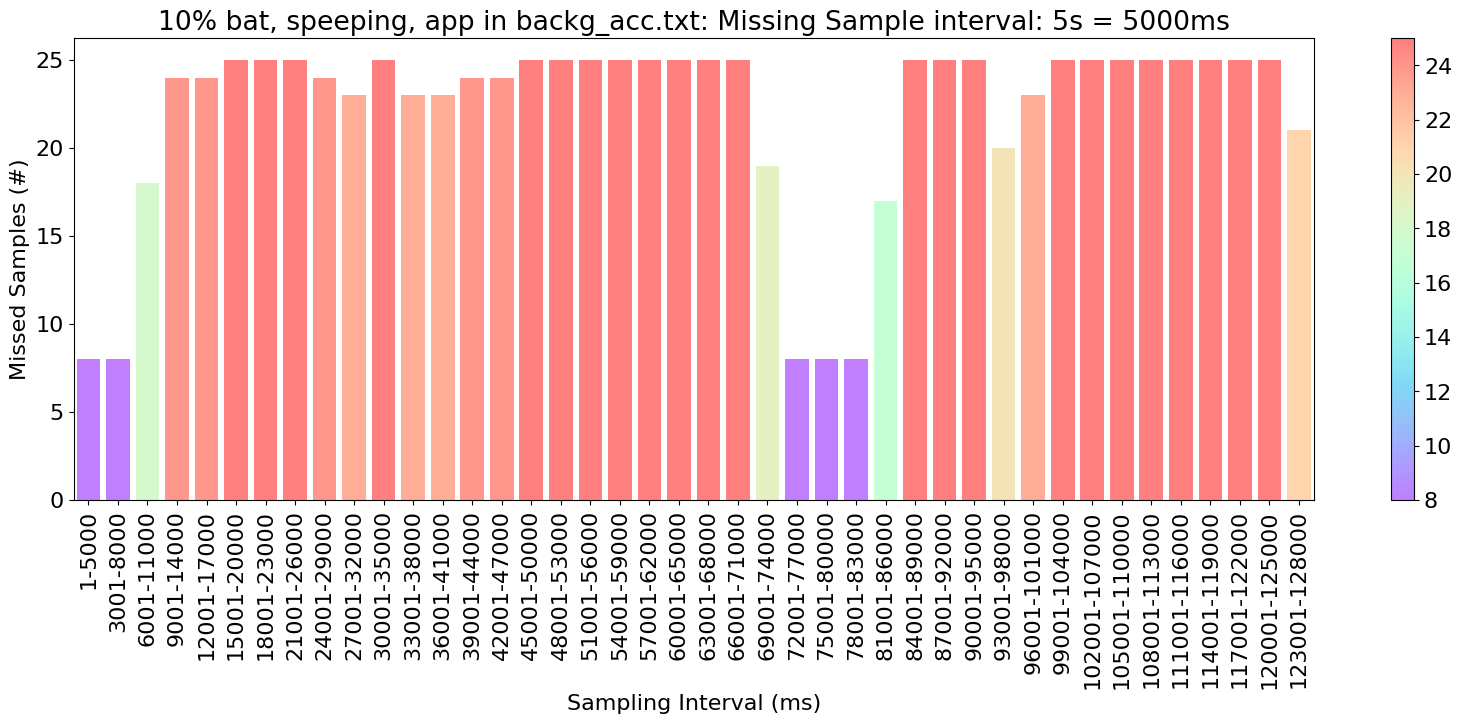

In [250]:
obj.plot_missing_window_color(5,3)

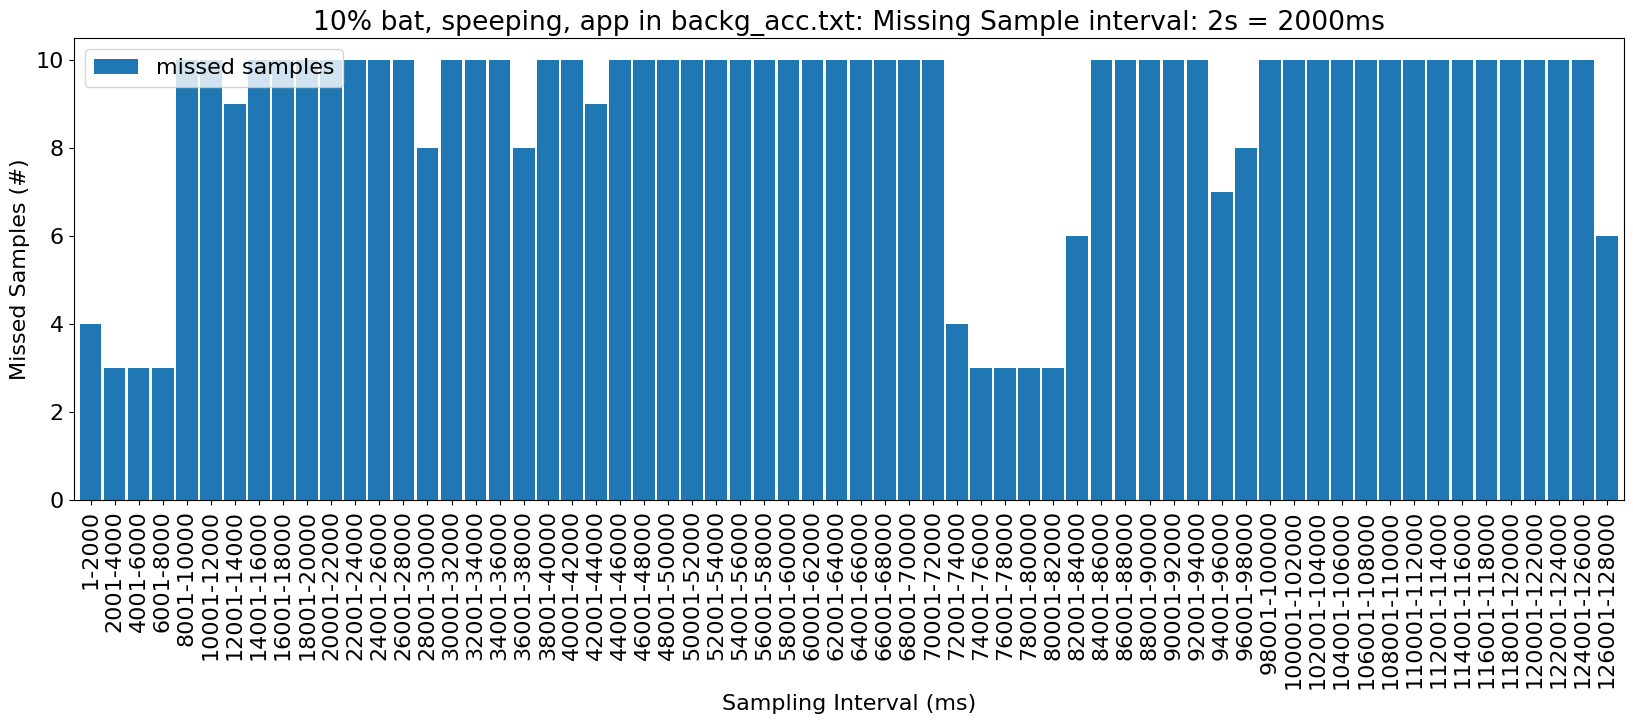

In [222]:
obj.plot_missing_window(2)

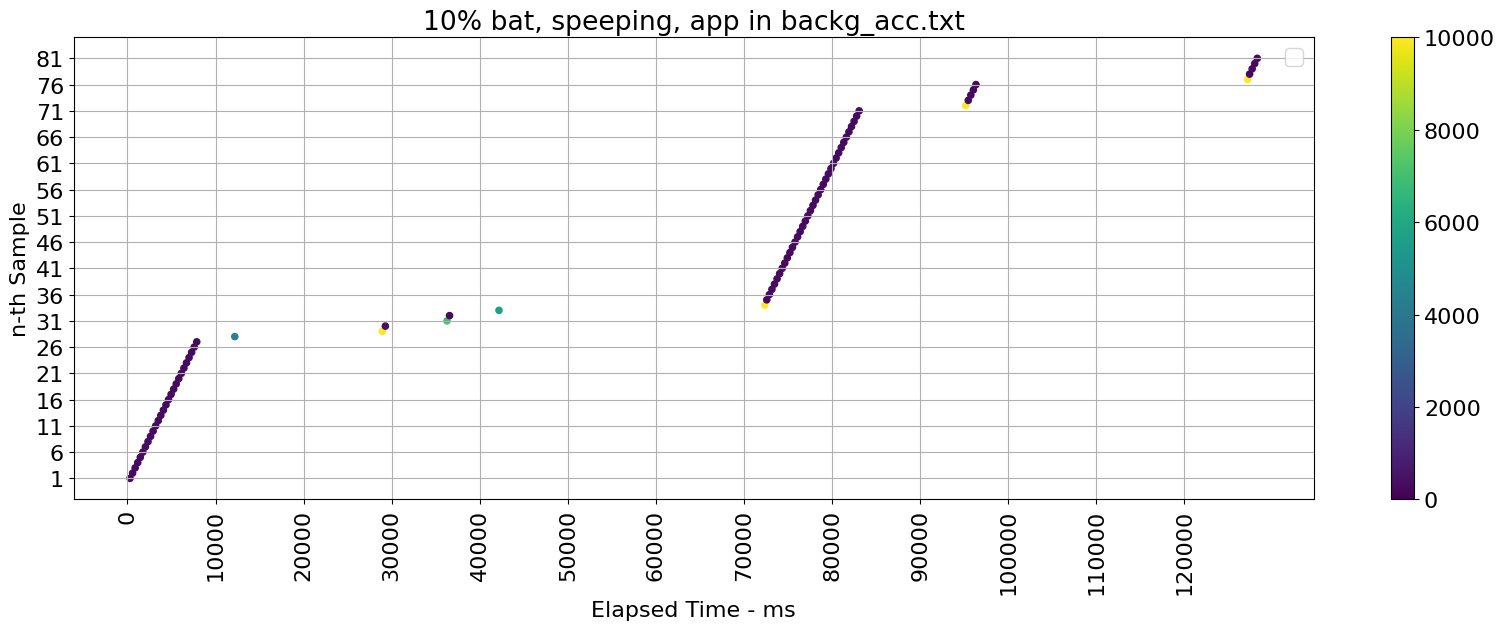

In [229]:
obj.plot1()

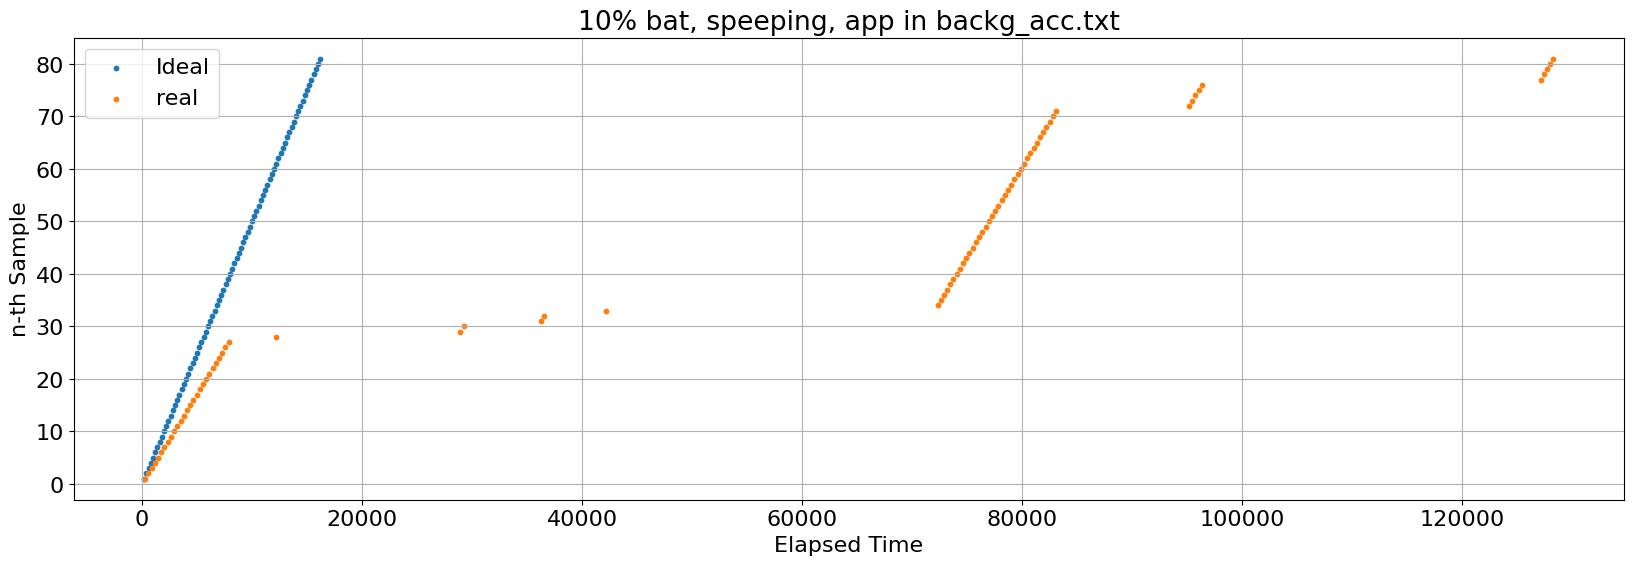

In [230]:
obj.plot2()

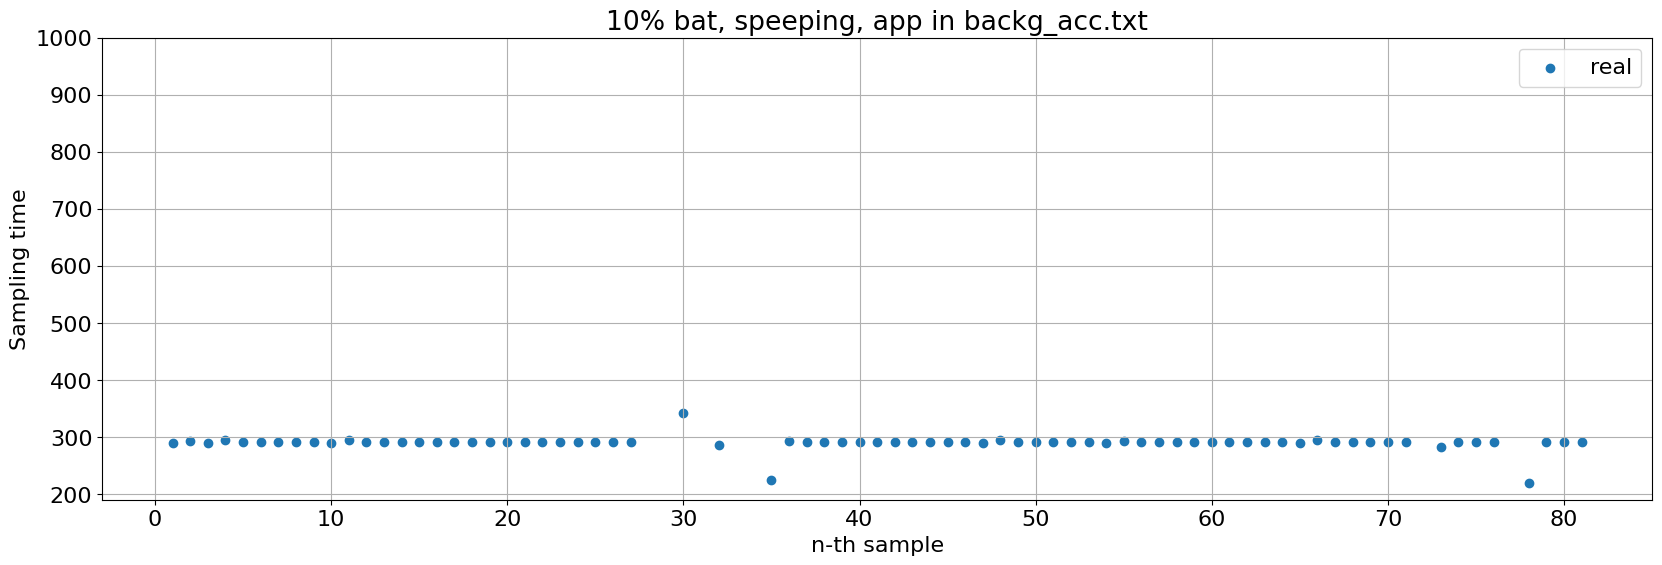

In [231]:
obj.plot3()

In [178]:
obj.print_raw_data()

,Acc_timestamp,Acc_x,Acc_y,Acc_z
0,1678595952366,2.242673,9.499506,-1.244866
1,1678595952657,2.2558336,9.5048895,-1.1497513
2,1678595952950,2.3700907,9.503095,-1.2209377
3,1678595953239,2.210968,9.529416,-0.87338024
4,1678595953531,2.2582264,9.544372,-1.14018
...,...,...,...,...
141,1678596328041,2.9635108,9.323035,-1.1048858
142,1678596328331,2.9102705,9.312267,-1.2532408
143,1678596328623,2.8929226,9.347562,-1.1958131
144,1678596328914,2.906083,9.330214,-1.0695918


In [179]:
obj.sensor_data_preprocessed

,time_stamp (ms),sample_count (#),time elapsed (s),time elapsed2 (s),time elapsed2 (ms),sample period (ms),ideal period (ms),ideal time elapsed2 (ms),Acc_x,Acc_y,Acc_z
0,1678595982451,1,30.085,0.290,290,290,200,200,-0.503091,0.10827523,9.684352
1,1678595982744,2,30.378,0.583,583,293,200,400,-0.5132605,0.11006984,9.702896
2,1678595983033,3,30.667,0.872,872,289,200,600,-0.5054838,0.10289137,9.684352
3,1678595983327,4,30.961,1.166,1166,294,200,800,-0.5102694,0.1058824,9.699904
4,1678595983618,5,31.252,1.457,1457,291,200,1000,-0.50368917,0.0951147,9.69153
...,...,...,...,...,...,...,...,...,...,...,...
76,1678596109347,77,156.981,127.186,127186,30848,200,15400,-0.4989035,0.07597212,9.690333
77,1678596109567,78,157.201,127.406,127406,220,200,15600,-0.48753762,0.0951147,9.688539
78,1678596109859,79,157.493,127.698,127698,292,200,15800,-0.48873404,0.093918286,9.689137
79,1678596110150,80,157.784,127.989,127989,291,200,16000,-0.48873404,0.09810573,9.690931
